<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_

#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 720 ms, sys: 1.14 s, total: 1.86 s
Wall time: 2.38 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        word_counts.update(captions[img_i][caption_i])

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [9]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [32]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True

        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        hiddens, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(hiddens)
        
        return logits        

In [33]:
network = CaptionNet(n_tokens)

In [34]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [89]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # # compute the loss function between logits_for_next and captions_ix_next
    # # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # # or by using ignore_index in some losses.

    logits_for_next = F.log_softmax(logits_for_next, -1)
    logp_next = torch.gather(logits_for_next, dim=2, index=captions_ix_next[:,:,None])

    loss = -logp_next.mean()
    return loss

In [82]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

torch.Size([5, 15, 10403]) torch.Size([5, 15]) torch.Size([5, 15])


Create ~~adam~~ your favorite optimizer for the network.

In [83]:
opt = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [84]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, test_size=0.1, random_state=42)

/Users/kgb/opt/anaconda3/envs/conda_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [85]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [86]:
generate_batch(img_codes,captions,3)

(tensor([[0.2589, 0.3027, 0.1389,  ..., 0.1685, 0.2127, 0.4236],
         [0.0905, 0.2065, 0.7938,  ..., 0.6485, 0.3871, 0.7858],
         [0.3557, 0.2748, 0.4221,  ..., 0.2609, 0.1895, 0.3115]]),
 tensor([[   1,   24,   29,    6,   46,  196,   82,   24,   83,   35,   24,  915,
            12,    2],
         [   1,   24,  122,   41, 3870,   58, 3869,   35,   45, 3871,   12,    2,
             3,    3],
         [   1,   24,  281,  474,    6, 1339,   58,   45, 1051,  185,  117,  291,
            12,    2]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### Tips
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0

In [87]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [113]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss_t.detach().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.detach().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]



Epoch: 0, train loss: 1.5335074937343598, val loss: 1.5182624578475952


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]



Epoch: 1, train loss: 1.5363510262966156, val loss: 1.8799551963806151


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]



Epoch: 2, train loss: 1.5273977041244506, val loss: 1.2984755992889405


100%|██████████| 50/50 [00:20<00:00,  2.42it/s]



Epoch: 3, train loss: 1.555373500585556, val loss: 1.5551638841629027


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]



Epoch: 4, train loss: 1.583922233581543, val loss: 1.5230923175811768


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]



Epoch: 5, train loss: 1.6355967807769776, val loss: 1.7279232025146485


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]



Epoch: 6, train loss: 1.5358629369735717, val loss: 1.4930682897567749


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]



Epoch: 7, train loss: 1.5507493126392364, val loss: 1.6659993648529052


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]



Epoch: 8, train loss: 1.5592723655700684, val loss: 1.6033196687698363


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]



Epoch: 9, train loss: 1.5780812096595764, val loss: 1.4475876331329345


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]



Epoch: 10, train loss: 1.5363440215587616, val loss: 1.4871597290039062


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]



Epoch: 11, train loss: 1.5151349890232086, val loss: 1.5184134244918823


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]



Epoch: 12, train loss: 1.4974591660499572, val loss: 1.564293122291565


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]



Epoch: 13, train loss: 1.527557156085968, val loss: 1.6744583606719972


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]



Epoch: 14, train loss: 1.533262268304825, val loss: 1.6599762916564942


100%|██████████| 50/50 [00:20<00:00,  2.47it/s]



Epoch: 15, train loss: 1.5720363783836364, val loss: 1.4207236766815186


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]



Epoch: 16, train loss: 1.58407080411911, val loss: 1.4512333869934082


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]



Epoch: 17, train loss: 1.5427721107006074, val loss: 1.5359780669212342


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]



Epoch: 18, train loss: 1.5356837618350982, val loss: 1.6847139358520509


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]



Epoch: 19, train loss: 1.5676971697807311, val loss: 1.666866087913513


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]



Epoch: 20, train loss: 1.574624137878418, val loss: 1.554759931564331


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]



Epoch: 21, train loss: 1.5228265380859376, val loss: 1.5614584684371948


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]



Epoch: 22, train loss: 1.5348570489883422, val loss: 1.6367408990859986


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]



Epoch: 23, train loss: 1.5321349430084228, val loss: 1.5671266794204712


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]



Epoch: 24, train loss: 1.533482530117035, val loss: 1.4498141050338744


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]



Epoch: 25, train loss: 1.5417720901966094, val loss: 1.602366065979004


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]



Epoch: 26, train loss: 1.4521044409275055, val loss: 1.2728737950325013


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]



Epoch: 27, train loss: 1.474995003938675, val loss: 1.4676795482635498


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]



Epoch: 28, train loss: 1.5502557730674744, val loss: 1.4128625988960266


100%|██████████| 50/50 [00:20<00:00,  2.45it/s]



Epoch: 29, train loss: 1.528106472492218, val loss: 1.6809377908706664


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]



Epoch: 30, train loss: 1.5582593333721162, val loss: 1.5917123556137085


  4%|▍         | 2/50 [00:01<00:24,  1.98it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(network.state_dict(), 'models/weights.pth')

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [91]:
network.load_state_dict(torch.load('models/weights.pth'))
network.eval()

from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/Users/kgb/opt/anaconda3/envs/conda_3.7/lib/python3.7/site-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /Users/kgb/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [99]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [118]:
from matplotlib import pyplot as plt
from cv2 import resize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299)).astype('float32') / 255.

--2021-11-01 17:41:50--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.12.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.12.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-11-01 17:41:50--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.14.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.14.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.04s   

2021-11-01 17:41:50 (1.27 MB/s) - ‘data/img.jpg’ saved [54731/54731]



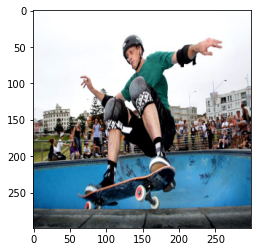

In [119]:
plt.imshow(img)

In [120]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on top of a ramp .
a man riding a skateboard on a skateboard .
a man riding a skateboard on top of a wooden ramp .
a man riding a skateboard on top of a wooden bench .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on a ramp .


--2021-11-01 17:41:36--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-11-01 17:41:36--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.005s  

2021-11-01 17:41:36 (20.8 MB/s) - ‘data/img.jpg’ saved [106870/106870]



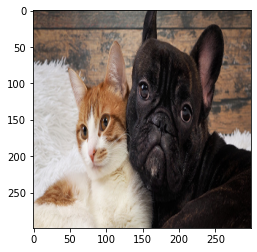

a black and white cat laying on a bed .
a black and white cat laying on a couch .
a black and white cat laying on a bed .
a black and white cat laying on a couch .
a cat is laying on a bed with a dog .
a cat is laying on a bed with a dog .
a black and white cat laying on a chair .
a cat is laying on a bed with a dog .
a black and white cat laying on a bed .
a black and white cat laying on a couch .


In [116]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more complex
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [125]:
def test(img_name):
    test_img = plt.imread('data/' + img_name)
    test_img = resize(test_img, (299, 299)).astype('float32') / 255.

    plt.imshow(test_img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(test_img, t=5.)[1:-1]))

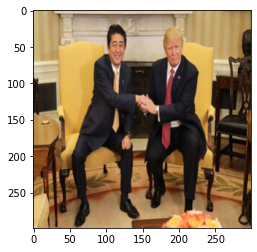

a man and woman standing in a room .
a man and woman standing next to each other .
a man and woman standing in a room .
a man standing in front of a man in a suit and tie .
a man and woman standing in a room .
a man and woman standing in a room .
a man and woman standing in a room with a man .
a man and woman standing in a room .
a man in a suit and tie standing in the middle of a room .
a man in a suit and tie standing in front of a tv .


In [126]:
test('handshake.jpg')

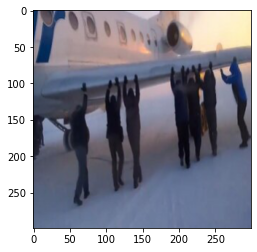

a group of people standing around a man on a skateboard .
a group of people standing next to a man in a suit .
a group of people standing on a snowy hill .
a group of people standing around a man holding a white and white dog .
a group of people standing around a large train .
a group of people standing next to a man .
a group of people standing around a large crowd of people .
a group of people standing in the snow with a ski lift .
a group of people standing around a man in a suit .
a group of people standing next to a man in a car .


In [127]:
test('airplane_passengers.jpg')

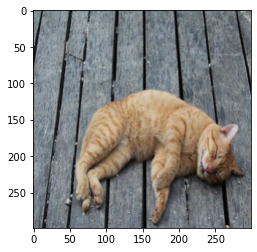

a cat is sitting on a chair next to a dog .
a cat is sitting on a bench .
a cat sitting on top of a wooden bench .
a cat is sitting on a wooden bench .
a cat sitting on a wooden bench next to a dog .
a cat is sitting on a bench .
a cat is sitting on a chair with a cat .
a cat is sitting on a chair with a cat .
a cat sitting on top of a wooden bench .
a cat is sitting on a bench next to a dog .


In [128]:
test('cat_sleep.jpg')

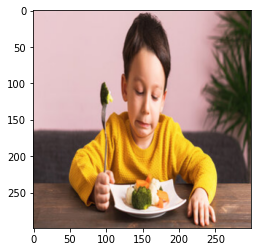

a man is eating a piece of pizza .
a woman holding a white plate of food .
a man with a white shirt and a white shirt eating a pizza .
a man is eating a piece of pizza .
a man holding a piece of pizza in a bowl .
a man is eating a piece of pizza .
a man is eating a piece of pizza .
a man is eating a piece of pizza on a table .
a man with a white shirt and a white shirt eating a pizza .
a man is eating a piece of pizza .


In [129]:
test('child_eating_vegetables.jpg')

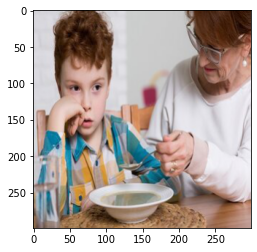

a man holding a white plate of food .
a woman holding a baby eating a doughnut .
a woman eating a doughnut and a cup of coffee .
a woman eating a donut and eating a doughnut .
a woman eating a doughnut and a cup of coffee .
a woman is eating a piece of pizza .
a man and woman eating a cake with a knife .
a man holding a white plate of food .
a man sitting at a table eating a meal
a man is eating a doughnut and a drink


In [131]:
test('child_eating.jpg')

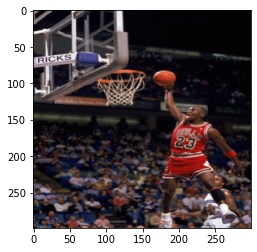

a man is standing on the side of a tennis court .
a man in a red shirt is holding a tennis racket .
a man riding a skateboard on a court .
a man in a white shirt and a white shirt is on a tennis court .
a man is playing a game of tennis on a tennis court .
a man is standing on a tennis court holding a tennis racket .
a man is standing on a tennis court holding a tennis racket .
a man in a white shirt and a white shirt is holding a tennis racket .
a man is standing on a tennis court holding a racquet .
a man is standing on a tennis court holding a tennis racket .


In [132]:
test('dunk.jpg')

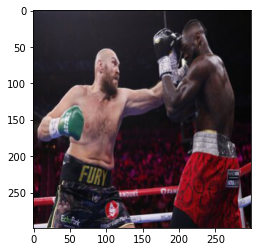

a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man in a red shirt and a woman on a skateboard .
a man riding a skateboard on top of a wooden bench .
a man riding a skateboard on top of a ramp .
a man in a black shirt and a boy riding a skateboard .
a man riding a skateboard on a ramp .
a man is holding a tennis racket in his hand .
a man riding a skateboard down a ramp .


In [133]:
test('fight.jpg')

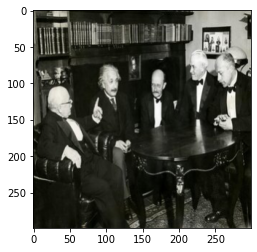

a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .


In [134]:
test('physicists.jpg')

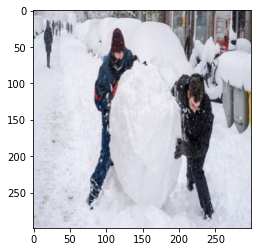

a group of people standing on top of a snow covered slope .
a group of people standing on top of a snow covered slope .
a man standing on top of a snow covered slope .
a man in a helmet is standing on the snow .
a man in a white jacket standing on a snow board .
a group of people standing on top of a snow covered slope .
a man in a helmet riding on a snowboard .
a man is standing on the snow in the snow .
a man in a red jacket riding a snowboard down a snow covered slope .
a man in a red jacket standing on top of a snow covered slope .


In [135]:
test('snowball.jpg')

### Now what?

Your model produces some captions, but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563